c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 37496/37496 [00:04<00:00, 9337.09 examples/s] 
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_17296\755609

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.254100,0.235066,0.909990,0.909765
2,0.159900,0.158279,0.941514,0.941413
3,0.122100,0.151433,0.946554,0.946488
4,0.105300,0.164348,0.949275,0.949268
5,0.082200,0.204344,0.949515,0.949496
6,0.052800,0.248095,0.948074,0.948043
7,0.036100,0.260253,0.949781,0.949803
8,0.024700,0.309349,0.949995,0.950041
9,0.011200,0.334434,0.951622,0.951619
10,0.001700,0.370087,0.951301,0.951303


c:\Users\User\anaconda3\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--google--electra-base-discriminator. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



 Evaluation results: {'eval_loss': 0.3344339430332184, 'eval_accuracy': 0.9516215062940047, 'eval_f1': 0.9516193446279739, 'eval_runtime': 151.1258, 'eval_samples_per_second': 248.111, 'eval_steps_per_second': 15.51, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.93      0.93      4553
     neutral       0.95      0.95      0.95     18568
    positive       0.96      0.96      0.96     14375

    accuracy                           0.95     37496
   macro avg       0.95      0.95      0.95     37496
weighted avg       0.95      0.95      0.95     37496



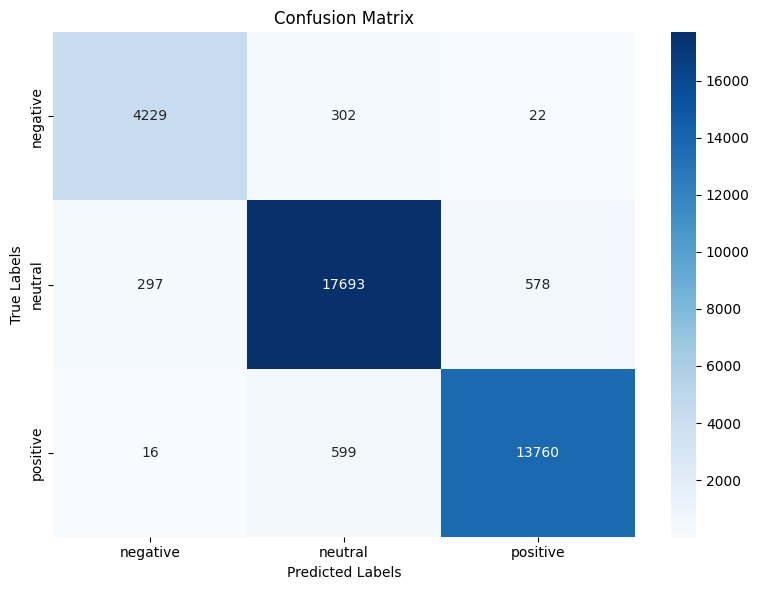

In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset

# Load dataset
data = pd.read_csv('youtube_com.csv', encoding='ISO-8859-1').dropna()
X = data['comment']
y = data['sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# ELECTRA model
model_name = 'google/electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)
)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_electra',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs_electra',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [2]:
trainer.save_model('Electrea_M')